# Principal Component Analysis

**Principal Component Analysis** (PCA) is one of the most common ways to perform dimensionality reduction. PCA takes a set of independent and dependent variables (dimensions) and creates a representation of the variable, or group of variables, that explains the most variance. In a regression or classification problem, that would mean reducing the number of variables or features to the most important aggregate components and perhaps discarding those which add little value to our model's predictive power. This is known as feature extraction, and can help simplify your model.  

### Load Packages

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

## Data Preparation

PCA works best when features are normally distributed and have low [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity). Because PCA is performing rotations in N-dimensional space, we typically need to standardize our data. Essentially, we are reducing the space that our data occupies in higher dimensions by standardizing the distribution, or scaling the range of values down to $[0, 1]$. Each method of scaling has its own data requirements, and there are several flavors of scaling and standardization. Therefore, you should first conduct a thorough data analysis of your features in order to make this assessment.

You may see the terms "scaling," "standardizing," "centering," and "normalizing" used interchangeably. This can be confusing, so let's break down these terms.

1. Scaling: Changes the range of the data but does not affect the distribution.

2. Standardizing: Changes the distribution of the data by calculating the standard normal score.

3. Centering: Shifts the distribution of the data so that the mean is zero.

4. Normalizing: [normalizes](https://en.wikipedia.org/wiki/Normalization_(statistics)) the rows of your dataset.

When using PCA to build a predictive model, we typically want to standardize the data with standard scalers. But some cases (e.g., cluster analysis or NLP) may require normalization of rows, not columns. There also may be other cases outside of PCA where you will need to scale or standardize.

[Here is a helpful guide](https://docs.google.com/spreadsheets/d/1woVi7wq13628HJ-tN6ApaRGVZ85OdmHsDBKLAf5ylaQ/edit?usp=sharing) for choosing which method is right for your data.

You can always check out the documentation for the implementation library, and scikit-learn's website has [another helpful guide](https://scikit-learn.org/stable/modules/preprocessing.html) to its preprocessing methods

### Download Wine Data 

In [ ]:
df_wine = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header=None)
display(df_wine.head())
display(df_wine.shape)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


(178, 14)

### Split Into Training and Test Data, and Then Standardize

In [ ]:
# Split into training and testing sets.
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0)

# Standardize the features.
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

## PCA from Scratch

### Calculate the Covariance Matrix

The [covariance](https://en.wikipedia.org/wiki/Covariance) of features $M$ and $N$ is defined as follows:

$$ \sigma_{MN}^2 = \frac{1}{n}\sum_i {(m_i-\mu_M)^2(n_i-\mu_N)^2}$$

- $\mu_M$ is the sample mean of feature $M$
- $\mu_N$ is the sample mean of feature $N$.

Covariance is an extension of variance; it is an indication of variability within a set of two features, just as variance is an indicator of variability within a feature. Don't worry too much about the math here. The implementation of PCA hides the details.

In [ ]:
cov_mat = np.cov(X_train_std.T)

### Calculcate the Eigenvectors and Eigenvalues

Eigenvectors represent the directional vectors that we search for in the N-dimensional space. Eigenvalues represent the length of these vectors, and they inform us of how much variance is explained by the Nth principal component. An eigenvalue of 1 means there is no more information gained beyond the original feature, so it is desirable to have principal components with values greater than 1.

In [ ]:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

### Calculate the Variance

Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace, we only select the subset of the eigenvectors (principal components) that contains most of the information (variance).

The eigenvalues define the magnitude of the eigenvectors, so we have to sort the eigenvalues by decreasing magnitude; we are interested in the top k eigenvectors based on the values of their corresponding eigenvalues.

But before we collect those k most informative eigenvectors, let’s plot the variance explained ratios of the eigenvalues.

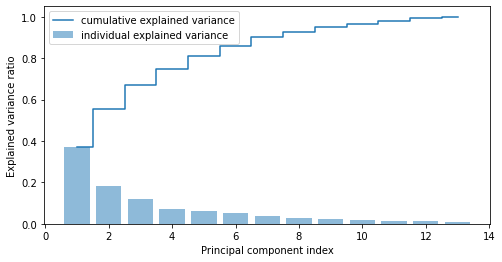

In [ ]:
# Calculate cumulative sum of explained variances.
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

ax, fig = plt.subplots(1,1,figsize=(8, 4))
# Plot explained variances.
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

Using PCA, we can see the explained variance of each component. The most variance is explained by the first principal component and drops off around 4 PCs. We can also see that the cumulative explained variance hits approximately 90% with 8 PCs.


### Feature Transformation
After we have successfully decomposed the covariance matrix into eigenvectors and eigenvalues , let’s now transform the Wine dataset onto the new principal component axes.

We will sort the eigenpairs by descending order of the eigenvalues, construct a projection matrix from the selected eigenvectors, and use the projection matrix to transform the data onto the lower-dimensional subspace.

By sorting the eigenpairs (vectors and their values), we can project that data into a lower dimensional space.

In [ ]:
# Make a list of (eigenvalue, eigenvector) tuples.
eigen_pairs = [(np.abs(eigen_vals[i]),
                eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low.
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


The result is a 13x2 projection matrix that is created from the top-2 eigenvectors. We can now use this projection matrix, $W$, to map any sample, $x$, to its 2-dimensional sample vector $x'$.

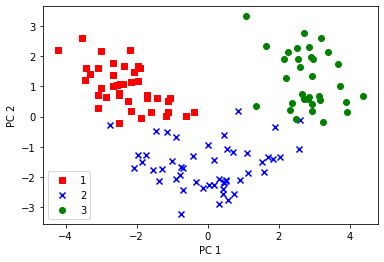

In [ ]:
# Project training data onto PC1 and PC2.
X_train_pca = X_train_std.dot(w)

# Visualize projection.
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], 
                X_train_pca[y_train==l, 1], 
                c=c, label=l, marker=m) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

That is how you can implement PCA from scratch using a covariance matrix.

## Using PCA With scikit-learn

Although the verbose approach in the previous subsection helped us to follow the inner workings of PCA, we will now discuss how to use the `PCA` class implemented in `scikit-learn`. 

In [ ]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)

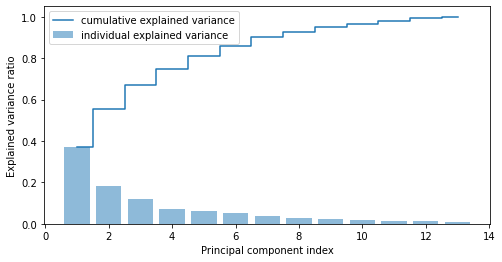

In [ ]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

ax, fig = plt.subplots(1,1,figsize=(8, 4))
# Plot explained variances.
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [ ]:
# Initialize PCA
pca = PCA(n_components=3)

# Fit and transform data.
X_train_pca_sl = pca.fit_transform(X_train_std)

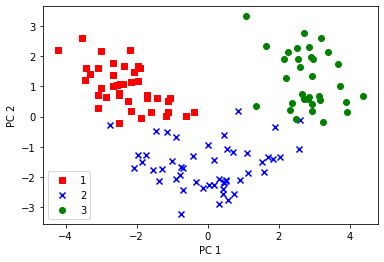

In [ ]:
# Visualize projection.
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca_sl[y_train==l, 0], 
                X_train_pca_sl[y_train==l, 1], 
                c=c, label=l, marker=m) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()